In [296]:
import datetime
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

In [297]:
def add_frequency(data):
    # 这里关于燃烧频率做一个假设规定，如果在数据中在某个地点A发生了燃烧，那么里该点五公里内点B再次发生燃烧
    # 视为被这个点所影响，通过被A影响点B的个数翻译A点的燃烧频率，作为题目要求的输入参数
    pass

def preprocess(data, Scaling_factor):
    # 把经纬度换算成以km为单位长度
    data['longitude'] = data['longitude'] * np.cos(data['latitude'] * math.pi / 180) *111
    data['latitude'] = data['latitude'] * 111
    Scaling_factor = data.std()
    sc = StandardScaler()
    output_data = sc.fit_transform(data[['longitude', 'latitude', 'frp']])

    return output_data, Scaling_factor

In [298]:
def get_timestamp_str(time_stamp):
    return datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d %H:%M:%S")

def DBSCAN_process(data, date_name, Scaling_factor, loss_function_facrors, Fire_Area, sigma = 3 ** 0.5):

    model = DBSCAN(eps=0.08, min_samples=3, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=1)
    y_pred = model.fit_predict(data)
    total_points = len(data)
    labels = model.labels_
    total_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # fig = plt.figure()
    #
    # ax1 = fig.add_subplot(311)
    # plt.scatter(data[:, 0], data[:, 1], marker='o')
    # plt.title('Initial distribution in date %s' %(date_name))
    # plt.sca(ax1)
    # ax3 = fig.add_subplot(313)
    # plt.scatter(data[:, 0], data[:, 1], c=y_pred)
    # plt.title('After DBSCAN clustering in date %s' %(date_name))
    # plt.sca(ax3)

    # result = "Total points is %d. \nTotal clusters is %d."%(total_points, total_clusters)
    # fig.text(0.1, 0.5, result)
    #
    # date_name = date_name.strftime("%Y_%m_%d_%H_%M_%S")
    # plt.savefig(('./output/'+date_name+'.pdf'))

    y_pred = y_pred.reshape(total_points, 1)
    y_pred = np.array(y_pred)
    after_DBSCAN = np.hstack((data,y_pred))
    after_DBSCAN = pd.DataFrame(after_DBSCAN, columns=['latitude', 'longitude', 'frp', 'label'])
    GroupBy = after_DBSCAN.groupby("label")

    sum_clusters_cost = 0
    porosity = 0.0

    for group_name, group in GroupBy:
        if group_name >= 0:
            temp = group.max() - group.min()
            width = (temp['longitude']) * Scaling_factor['longitude']
            height = (temp['latitude']) * Scaling_factor['latitude']
            if width < height:
                temp = width
                width = height
                height = temp
            porosity = get_porosity(sigma)
            single_cluster_cost, fire = get_cost(width,height,sigma)
            sum_clusters_cost = sum_clusters_cost + single_cluster_cost
            fire_area_new_row = np.array([date_name, group_name, width, height, fire]).reshape(1,5)
            Fire_Area = np.concatenate((Fire_Area, fire_area_new_row),axis=0)
    loss_function_new_row = np.array([date_name, sum_clusters_cost, porosity]).reshape(1,3)
    loss_function_facrors = np.concatenate((loss_function_facrors, loss_function_new_row),axis=0)

    return loss_function_facrors, Fire_Area

In [299]:
def get_RD(m, n,sigma = 3 ** 0.5):
    if 0 <= m < 18:
        if 0 < n <= 17:
            return 4
        elif 17 < n <= 35:
            return 6
        elif 35 < n <= 52:
            return 10
        elif 52 < n <= 70:
            return 12
    elif 18 <= m < 35:
        if 0 < n <= 17:
            return 6
        elif 17 < n <= 35:
            return 9
        elif 35 < n <= 52:
            return 15
        elif 52 < n <= 70:
            return 18
    elif 35 <= m < 53:
        if 0 < n <= 17:
            return 10
        elif 17 < n <= 35:
            return 15
        elif 35 < n <= 52:
            return 25
        elif 52 < n <= 70:
            return 30
    if 53 <= m < 70:
        if 0 < n <= 17:
            return 12
        elif 17 < n <= 35:
            return 18
        elif 35 < n <= 52:
            return 30
        elif 52 < n <= 70:
            return 36
    else:
        r = 5
        d = sigma * r
        if sigma == 3 ** 0.5:
            return math.ceil(3*(((m-2*r)/d+1)+((n-60-2*r)/d+1)))
        else: # 这里就是阈值不为默认 人为输入的时候
            return math.ceil(3*(((m-10)/(5*sigma)+1)+((n-70)/(5*sigma)+1)))

def get_SSI(m, n):
    if m < 30:
        return 2 * math.ceil(n/10)
    elif m < 60:
        return 4 * math.ceil(n/10)
    else:
        return math.ceil(2/5*(m+n-60))

def get_porosity(sigma=3**0.5):
    r = 5
    d = sigma * r
    return (16 * (((d ** 2 / 4) * (1 - math.sqrt((4 * r ** 2 / d ** 2) - 1))) - ((math.pi / 4 - math.acos(d / (2 * r))) * r ** 2)))/ ((9 * math.pi * r ** 2) - 24 * ((r ** 2 * math.acos(d / (2 * r))) - (d * math.sqrt(r ** 2 - d ** 2 / 4) / 2)))

def get_cost(width, height, sigma):
    Fire_Area = width * height
    SSA_num = get_SSI(width, height)
    RD_num = get_RD(width, height, sigma)
    all_money_cost = (RD_num + SSA_num) * 10000
    return all_money_cost, Fire_Area

In [300]:
def get_sigma_adjust_figure(loss_function_facrors):
    loss_function_facrors = np.delete(loss_function_facrors,0,axis=0)
    sc = MinMaxScaler()
    date_column = loss_function_facrors[:,0].reshape(-1,1)
    porosity_column = loss_function_facrors[:,2].reshape(-1,1).astype(float)
    money_column = sc.fit_transform(loss_function_facrors[:,1].reshape(-1,1)).astype(float)
    F1_score_column = (porosity_column + 40 * money_column)
    loss_function_facrors =  np.concatenate((date_column, F1_score_column),axis=1)
    return loss_function_facrors

In [301]:
def process(sigma):
    print('sigma is ', sigma)
    data = pd.read_csv("./data/fire_archive_M6_96619.csv")
    data['acq_date'] = pd.to_datetime(data['acq_date'])
    GroupBy = data.groupby("acq_date")
    Scaling_factor = [] # 这个是经纬度标准化的缩放系数，归一化后算成本的时候要折算回去
    Fire_Area = np.array([['Time','Cluster_Num','Width','Height','Area']])
    loss_function_facrors = [['Time','Cost','Porosity']]

    for name,group in GroupBy:
        temp_group, Scaling_factor = preprocess(group, Scaling_factor)
        loss_function_facrors, Fire_Area = DBSCAN_process(temp_group, name, Scaling_factor, loss_function_facrors, Fire_Area, sigma)

    loss_function_facrors = pd.DataFrame(get_sigma_adjust_figure(loss_function_facrors),columns=['Datetime','F1_score'])
    Fire_Area = np.delete(Fire_Area, 0, axis=0)
    Fire_Area = pd.DataFrame(Fire_Area,columns=['Datetime','Cluster_Num','Width','Heigh','Area'])
    sigma_adjust_name = 'sigma_adjust/sigma_'+str(sigma)+'.csv'
    Fire_Area_Name = 'Fire_Area/fire_area_sigma_'+str(sigma)+'.csv'
    loss_function_facrors.to_csv(sigma_adjust_name, index=0)
    Fire_Area.to_csv(Fire_Area_Name, index=0)

    del data, GroupBy, Scaling_factor, Fire_Area, loss_function_facrors

sigma_list = [1.414, 1.656, 1.758, 1.838, 1.900, 1.960, 2.000]
for sigma in sigma_list:
    process(sigma)

sigma is  1.414
sigma is  1.656
sigma is  1.758
sigma is  1.838
sigma is  1.9
sigma is  1.96
sigma is  2.0


C:\Users\yangkaixing\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\yangkaixing\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\yangkaixing\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\yangkaixing\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await

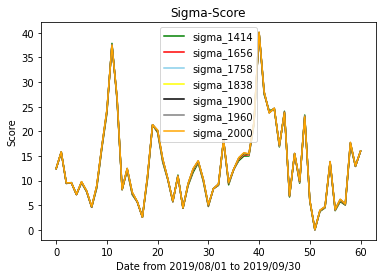

In [302]:
def plot_sigma_figure():
    sigma_1414 = pd.read_csv('sigma_adjust/sigma_1.414.csv')
    sigma_1656 = pd.read_csv('sigma_adjust/sigma_1.656.csv')
    sigma_1758 = pd.read_csv('sigma_adjust/sigma_1.758.csv')
    sigma_1838 = pd.read_csv('sigma_adjust/sigma_1.838.csv')
    sigma_1900 = pd.read_csv('sigma_adjust/sigma_1.9.csv')
    sigma_1960 = pd.read_csv('sigma_adjust/sigma_1.96.csv')
    sigma_2000 = pd.read_csv('sigma_adjust/sigma_2.0.csv')
    x = range(61)
    plt.title('Sigma-Score')
    plt.plot(x, sigma_1414['F1_score'], color='green', label='sigma_1414')
    plt.plot(x, sigma_1656['F1_score'], color='red', label='sigma_1656')
    plt.plot(x, sigma_1758['F1_score'], color='skyblue', label='sigma_1758')
    plt.plot(x, sigma_1838['F1_score'], color='yellow', label='sigma_1838')
    plt.plot(x, sigma_1900['F1_score'], color='black', label='sigma_1900')
    plt.plot(x, sigma_1960['F1_score'], color='grey', label='sigma_1960')
    plt.plot(x, sigma_2000['F1_score'], color='orange', label='sigma_2000')
    plt.legend()
    plt.xlabel('Date from 2019/08/01 to 2019/09/30')
    plt.ylabel('Score')
    plt.savefig('./sigma_adjust/sigma_score.pdf')
    plt.show()

# plot_sigma_figure()

In [325]:
def analyze_area():
    fire_area = pd.read_csv('./Fire_Area/fire_area_sigma_1.656.csv')
    result = fire_area.describe()
    result.to_csv('./Fire_Area/Fire_Area_Analysis.csv')
# analyze_area()

def get_sigma_porosity():
    sigma_list = [1.414, 1.656, 1.758, 1.838, 1.900, 1.960, 2.000]
    result = pd.DataFrame([])
    for sigma in sigma_list:
        result[str(sigma)]=get_porosity(1.758)
    result.to_csv('Rs_result.csv',index=0)
print(get_porosity(1.960))

0.10250240193353893


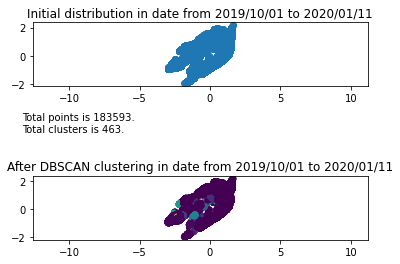

latitude       907.124117
longitude     1082.433957
brightness      28.605291
scan             0.811106
track            0.247695
acq_time       622.267670
confidence      25.041968
bright_t31      13.348698
frp            241.045287
dtype: float64


In [311]:
def get_clusters_like_question():
    data = pd.read_csv('./data/fire_nrt_M6_96619.csv')
    data['longitude'] = data['longitude'] * np.cos(data['latitude'] * math.pi / 180) *111
    data['latitude'] = data['latitude'] * 111
    sc = StandardScaler()
    scale = data.std()
    data = sc.fit_transform(data[['longitude', 'latitude', 'frp']])
    model = DBSCAN(eps=0.08, min_samples=3, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=1)
    y_pred = model.fit_predict(data)
    total_points = len(data)
    labels = model.labels_
    total_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax1.axis('equal')
    plt.scatter(data[:, 0], data[:, 1], marker='o')
    plt.title('Initial distribution in date from 2019/10/01 to 2020/01/11')
    plt.sca(ax1)
    ax3 = fig.add_subplot(313)
    ax3.axis('equal')
    plt.scatter(data[:, 0], data[:, 1], c=y_pred)
    plt.title('After DBSCAN clustering in date from 2019/10/01 to 2020/01/11')
    plt.sca(ax3)

    result = "Total points is %d. \nTotal clusters is %d."%(total_points, total_clusters)
    fig.text(0.1, 0.5, result)

    plt.savefig('./output/total_distribution.pdf')
    plt.show()
    print(scale)

get_clusters_like_question()

In [329]:
print("测试代码！")
print(318.9936*1.5)
print("测试完成！")

测试代码！
478.4904
测试完成！
